In [1]:
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

### Requirement

In [4]:
repo_dir = "/home/bruce1996/repo/LIHC_anomaly_detection/"

with open(repo_dir + 'data/scRNA-raw-data/GSE149614_coding_gene_hepatocyte_normalized.pkl', 'rb') as f :
    exp_m = pickle.load(f)
f.close()

with open(repo_dir + "data/Coding-gene-information/ensembl2hgnc.pkl",'rb') as f :
    ens2hgsc = pickle.load(f)
f.close()

hvg_df = pd.read_csv(repo_dir + 'data/scRNA-related-data/seurat_hvg1346_list.txt',sep='\t',index_col=0)
metadata = pd.read_csv(repo_dir + 'data/scRNA-raw-data/GSE149614_HCC.metadata.txt',sep='\t',index_col=0)
metadata = metadata.loc[exp_m.columns,:]
vote = pd.read_csv(repo_dir + "data/Ensemble-leanring-result/with_synthetic/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

### The intersection between voted genes and HVGs

In [5]:
from matplotlib_venn import venn2

In [14]:
hvg_df = pd.read_csv(repo_dir + 'data/scRNA-related-data/seurat_hvg1346_list.txt',sep='\t',index_col=0)
hvgs = hvg_df.EnsID.values
vote = pd.read_csv(repo_dir + "data/Ensemble-leanring-result/with_synthetic/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

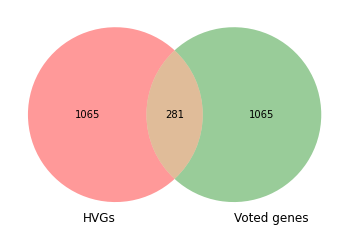

In [15]:
venn2([set(hvgs),set(voted_gene)],set_labels=["HVGs","Voted genes"])
plt.savefig(repo_dir + "result/scRNA_gene_variance/voted_gene_hvgs_venn_diagram.pdf",format='pdf',dpi=300)

### Voted genes/ HVGs mean expression and variance 

In [16]:
repo_dir = "/home/bruce1996/repo/LIHC_anomaly_detection/"

with open(repo_dir + 'data/scRNA-raw-data/GSE149614_coding_gene_hepatocyte_normalized.pkl', 'rb') as f :
    exp_m = pickle.load(f)
f.close()

hvg_df = pd.read_csv(repo_dir + 'data/scRNA-related-data/seurat_hvg1346_list.txt',sep='\t',index_col=0)
hvgs = hvg_df.EnsID.values
vote = pd.read_csv(repo_dir + "data/Ensemble-leanring-result/with_synthetic/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

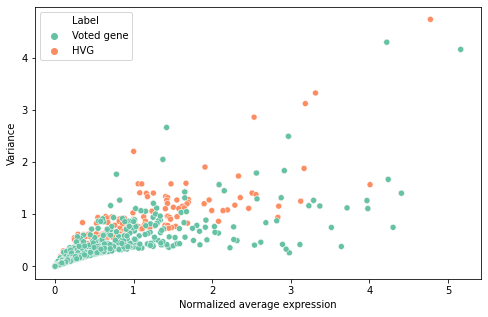

In [18]:
mean = exp_m.mean(axis=1)
variance = exp_m.var(axis=1)
df = pd.concat([pd.DataFrame({'Mean' : mean[hvgs],'Variance' : variance[hvgs],'Label' : ['HVG'] * len(hvgs)}),
                pd.DataFrame({'Mean' : mean[voted_gene],'Variance' : variance[voted_gene],'Label' : ['Voted gene'] * len(voted_gene)})])

plt.figure(figsize=(8,5))
sns.scatterplot(data = df,x='Mean',y='Variance',hue='Label',palette='Set2',hue_order=['Voted gene','HVG'])
plt.xlabel("Normalized average expression")
plt.savefig(repo_dir + "result/scRNA_gene_variance/mean_variance_scatter_plot.pdf",format='pdf',dpi=300)


### Spearman correlation between gene & vote number

In [19]:
repo_dir = "/home/bruce1996/repo/LIHC_anomaly_detection/"
with open(repo_dir + 'data/scRNA-raw-data/GSE149614_coding_gene_hepatocyte_normalized.pkl', 'rb') as f :
    exp_m = pickle.load(f)
f.close()

vote = pd.read_csv(repo_dir + "data/Ensemble-leanring-result/with_synthetic/ensemble_hbv_only_np_ratio_35_vote_result.txt",sep='\t',index_col=0)
voted_gene = list(set(vote.index[vote['Vote'] > 0]).intersection(exp_m.index))

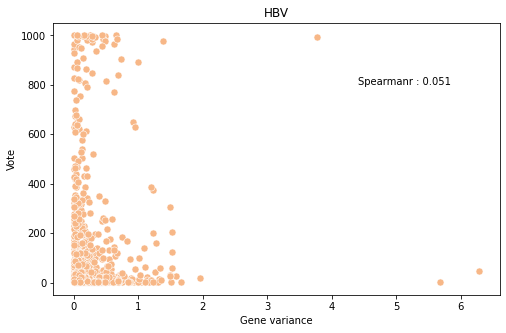

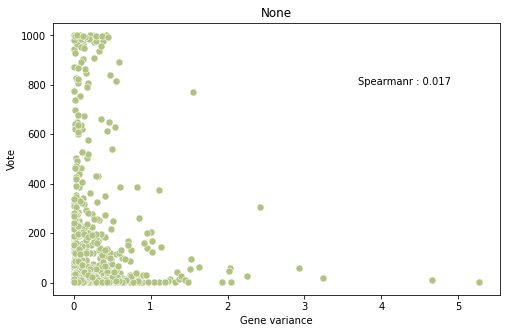

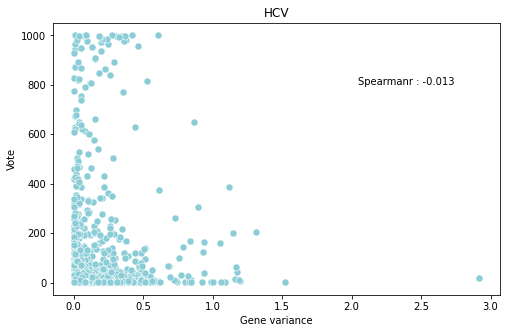

In [20]:
# Only calculate the genes which vote number > 0.
vote_exp_m = exp_m.loc[voted_gene,:]
colormap = ['#F7B787','#B1C381','#8ACDD7']
# Calculate the correlation in different virus groups (HBV, HCV and none)
for idx,virus in enumerate(metadata.virus.unique()) :
    df = vote_exp_m.loc[:,np.where(metadata.virus == virus,True,False)]
    plot_df = pd.DataFrame({'Variance' : df.var(axis=1),'Vote' : vote.loc[voted_gene,'Vote'].values},index=voted_gene)
    #plot
    plt.figure(figsize=(8,5))
    sns.scatterplot(data=plot_df,x='Variance',y='Vote',s=50,color=colormap[idx])
    rho,pval = stats.spearmanr(plot_df['Variance'].values, plot_df['Vote'].values)
    plt.title(virus)
    plt.xlabel('Gene variance')
    plt.text(plot_df['Variance'].max() * 0.7,800,"Spearmanr : %0.3f" % rho)
    plt.savefig(repo_dir + "result/scRNA_gene_variance/%s_scc_of_gene_variance_and_vote_number.pdf" % virus,format='pdf',dpi=300)
    #plt.savefig("/home/bruce1996/data/LIHC_anomaly_detection/manuscript/material/scRNA_measurement/%s_scc_of_gene_variance_and_vote_number.pdf" % virus,dpi=300,format='pdf')